In [5]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import keras 

df = pd.read_pickle('dataset/train_dataset.pkl')


pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None) #50 for truncated view, -1 for full view

In [6]:

def get_train_test_dataset():
    split_date = '2015-12-28 10:29:13'
    data_train = df.loc[df['Timestamp'] <= split_date].copy()
    data_test = df.loc[df['Timestamp'] > split_date].copy()

    return data_train, data_test

In [126]:
training, test = get_train_test_dataset()
test = test.reset_index(drop=True)

cols_numeric = list(df.columns)

cols_numeric.remove('index')
cols_numeric.remove('attack')


#Transform to numeric data to be able to do the SC
# training['Timestamp'] = pd.to_numeric(training['Timestamp'])
training['Normal/Attack'].replace(['Normal', 'Attack'],
                        [0, 1], inplace=True)

# test['Timestamp'] = pd.to_numeric(test['Timestamp'])
test['Normal/Attack'].replace(['Normal', 'Attack'],
                        [0, 1], inplace=True)

# We only fit on the trainset to avoid data leakage from the testset

data_num = training[cols_numeric]
train_set = (data_num-data_num.min())/(data_num.max()-data_num.min())


test_num = test[cols_numeric]
test_set = (test_num-test_num.min())/(test_num.max()-test_num.min())

# scaler = StandardScaler().fit(data)
# train_set = scaler.transform(data)


# scaler = StandardScaler().fit(test)
# test_set = scaler.transform(test)

In [153]:
cols_numeric = list(df.columns)
cols_numeric.remove('Timestamp')
cols_numeric.remove('Normal/Attack')
cols_numeric.remove('index')
cols_numeric.remove('attack')


for col in cols_numeric:
    
    var = np.var(test_set[col])
    if var == 0 or np.isnan(var):
        print(col)
        test_set[col] = test_set[col].fillna(0)
        
    # var = np.var(train_set[col])
    # if var == 0 or np.isnan(var):
    #     print(col)
    #     train_set[col] = train_set[col].fillna(0)

P301


backup not use (anomaly)

<AxesSubplot:>

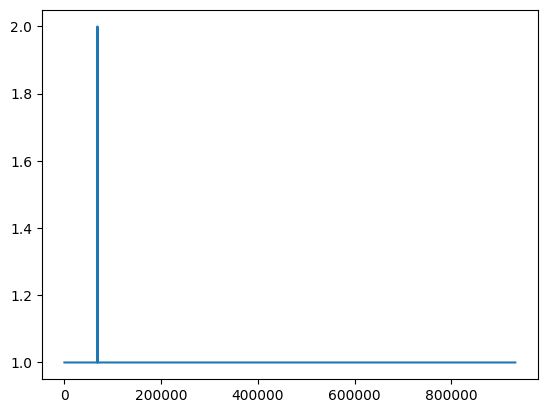

In [156]:
df['P301'].plot()

In [8]:
import numpy as np

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])

    return np.array(Xs), np.array(ys)

In [113]:

cols = ['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201',
       'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204',
       'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302',
       'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401',
       'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502',
       'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501',
       'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603']

to_remove = ['P202','P401','P404','P502','P601','P603']
cols = [i for i in cols if i not in to_remove]
feature = ['PIT503']
cols.remove(feature[0])

# size of sequence
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]
train = train_set.loc[0:20000-1, cols+feature]
test = test_set.loc[0:20000-1, cols+feature]

X_train, y_train = create_dataset(train[cols], train[feature], TIME_STEPS)
X_test, y_test = create_dataset(test[cols], test[feature], TIME_STEPS)


In [130]:
date_test = test.loc[0:20000-1-TIME_STEPS, 'Timestamp']


In [10]:
print(X_test.shape, y_test.shape)

(19970, 30, 44) (19970, 1)


In [11]:
print(X_train.shape, y_train.shape)

(19970, 30, 44) (19970, 1)


In [13]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=y_train.shape[1])))
model.compile(loss='mae', optimizer='adam')

2022-09-20 17:51:27.230503: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [83]:
# model = keras.Sequential()
# model.add(keras.layers.LSTM(64, activation='softmax', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
# model.add(keras.layers.LSTM(32, activation='relu', return_sequences=False))
# # model.add(Dropout(0.5))
# model.add(keras.layers.Dense(y_train.shape[1]))

# model.compile(optimizer='adam', loss="mean_squared_error", run_eagerly=True)#, loss='mse')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                27904     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 64)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            65        
 ibuted)                                                

In [15]:
# history = model.fit(
#     X_train, y_train,
#     epochs=10,
#     batch_size=32,
#     validation_split=0.1,
#     shuffle=False
# )

history = model.fit(
    X_train, y_train,
    epochs=2)

Epoch 1/2
625/625 [==============================] - 16s 20ms/step - loss: 0.0455
Epoch 2/2
625/625 [==============================] - 14s 23ms/step - loss: 0.0247


In [16]:
X_test_pred = model.predict(X_test)


625/625 [==============================] - 5s 7ms/step


In [32]:
X_test_pred.shape

(19970, 30, 1)

In [61]:
y_test.shape

(19970, 1)

In [43]:
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [150]:
X_test_pred[0]

array([[0.6582625 ],
       [0.6772003 ],
       [0.679907  ],
       [0.6794462 ],
       [0.6787398 ],
       [0.67821646],
       [0.67786133],
       [0.67761505],
       [0.6774354 ],
       [0.6772983 ],
       [0.67719054],
       [0.67710435],
       [0.6770351 ],
       [0.6769793 ],
       [0.67693424],
       [0.676898  ],
       [0.67686903],
       [0.6768458 ],
       [0.67682713],
       [0.6768123 ],
       [0.6768005 ],
       [0.6767911 ],
       [0.67678356],
       [0.6767776 ],
       [0.67677295],
       [0.67676914],
       [0.6767663 ],
       [0.6767639 ],
       [0.676762  ],
       [0.67676044]], dtype=float32)

(0.0, 1.2)

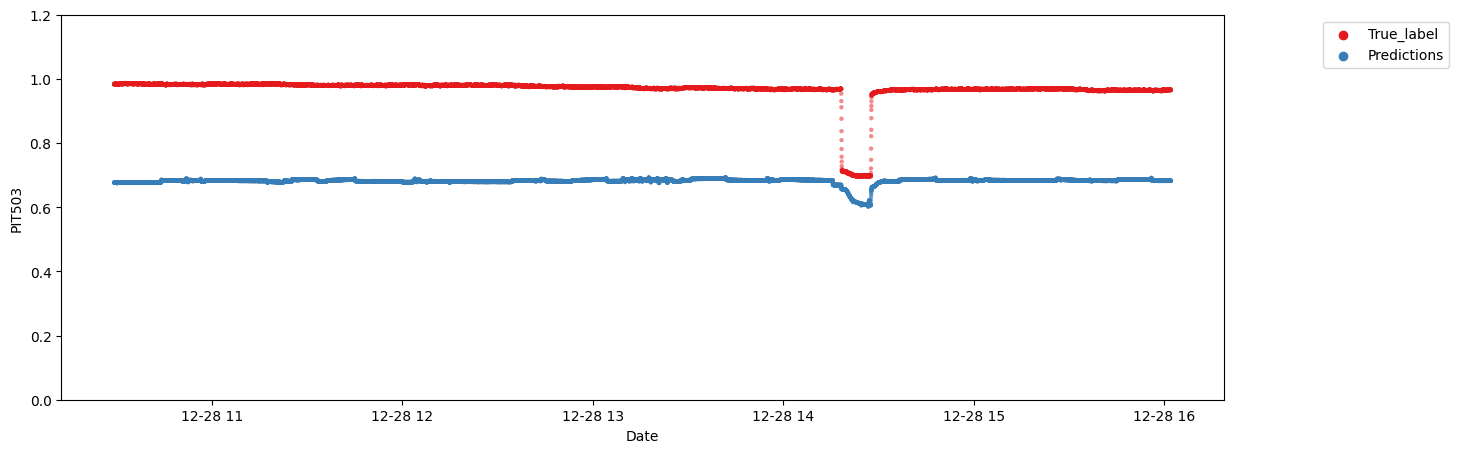

In [152]:
how_much_in_futur = 29

arr = [float(X_test_pred[i][how_much_in_futur]) for i in range(len(X_test_pred))]
predictions = pd.DataFrame({'Predictions': arr})
true_label = pd.DataFrame({'True_label': y_test.flatten()})

result = pd.concat([true_label, predictions, date_test], axis=1)

data_melt = pd.melt(result.reset_index(), id_vars=['Timestamp'], value_vars=['True_label', 'Predictions'])
g = sns.scatterplot(x='Timestamp', y='value', hue='variable', data=data_melt, palette='Set1', alpha=0.5, s=10, linewidth=0, legend='full')
g.set(xlabel='Date', ylabel='PIT503')
g.legend(loc='upper right', bbox_to_anchor=(1.2, 1), ncol=1)
g.figure.set_size_inches(15, 5)
g.set_ylim([0, 1.2])

In [90]:

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df.shape

(448135, 0)

In [98]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(index=test_set[TIME_STEPS:20000].index)
test_score_df['loss'] = test_mae_loss
# test_score_df['threshold'] = THRESHOLD
# test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
# test_score_df[feature] = test[TIME_STEPS:][feature]

In [ ]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();